[JAX](https://www.youtube.com/watch?v=WdTeDXsOSj4) implementation of [@karpathy](https://twitter.com/karpathy)'s notebook shared in the context of video [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I). The implementation by Karpathy is in Toch and implements a neural network based on [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).
The notebook shared by [Andrej Karpathy](https://github.com/karpathy): [build_makemore_mlp.ipynb](https://colab.research.google.com/drive/1YIfmkftLrz6MPTOO9Vwqrop2Q5llHIGK?usp=sharing)

In [1]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

In [2]:
jax.device_count()

8

In [3]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [4]:
!pip install jax_metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jax: filename=jax-0.4.8-py3-none-any.whl size=1439691 sha256=8f9ba28394fbb475d9413b203b194842fe233298cfb869d22a81d38bab00e6e4
  Stored in directory: /root/.cache/pip/wheels/05/94/dc/81042da9bced43ff430bc02043d213d9e4b210b584c39e31c1
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.25
    Uninstalling jax-0.3.25:
      Successfully uninstalled jax-0.3.25
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

In [5]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-04-17 08:44:06--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-04-17 08:44:06 (8.12 MB/s) - ‘names.txt’ saved [228145/228145]



In [8]:
import jax
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
# import jax_metrics as jm

from jax import grad, jit, random, value_and_grad
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [9]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [10]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [11]:
len(words)

32033

In [12]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [13]:
X, Y = [], []
block_size = 3
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = jnp.array(X)
Y = jnp.array(Y)
print(X.shape, Y.shape)

(228146, 3) (228146,)


In [14]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = jnp.array(X)
  Y = jnp.array(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n_words_multiple_eight = 8*(len(words)//8)
words = words[:n_words_multiple_eight]
n1 = int(6*len(words)/8)
n2 = int(7*len(words)/8)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

(171195, 3) (171195,)
(28411, 3) (28411,)
(28533, 3) (28533,)


In [15]:
from jax import random

In [16]:
from jax import nn
from operator import getitem

In [17]:
@jax.jit
def cross_entropy_loss(logits, labels):
    logits = nn.log_softmax(logits)
    loss = jax.vmap(getitem)(logits, labels)
    loss = -loss.mean()
    return loss

In [52]:
from typing import NamedTuple, Tuple
import functools

class Params(NamedTuple):
  C: jnp.ndarray
  W1: jnp.ndarray
  b1: jnp.ndarray
  W2: jnp.ndarray
  b2: jnp.ndarray

def init(rng) -> Params:
  """Returns the initial model params."""
  C_key, W1_key, b1_key, W2_key, b2_key = random.split(rng, num=5)
  C = random.normal(C_key, (27, 10), dtype=jnp.float32)
  W1 = random.normal(W1_key, (30, 200), dtype=jnp.float32)
  b1 = random.normal(b1_key, (200,), dtype=jnp.float32)
  W2 = random.normal(W2_key, (200, 27), dtype=jnp.float32)
  b2 = random.normal(b2_key, (27,), dtype=jnp.float32)
  return Params(C, W1, b1, W2, b2)

def loss_fn(params, X: jnp.ndarray, Y: jnp.ndarray, key) -> jnp.ndarray:
  # minibatch construct
  ix = random.randint(key, (32,),  0, X.shape[0])
  # forward pass
  emb = params.C[X[ix]] # (32, 3, 2)
  h = jnp.tanh(jnp.dot(emb.reshape(-1, 30), params.W1) + params.b1) # (32, 100)
  logits = jnp.dot(h, params.W2) + params.b2 # (32, 27)
  loss = cross_entropy_loss(logits=logits, labels=Y[ix])
  return loss

def update(params, X: jnp.ndarray, Y: jnp.ndarray, lr, key):
  loss, grads = value_and_grad(loss_fn)(params, X, Y, key)
  return loss, jax.tree_map(
      lambda p, g: p - lr * g, params, grads
  )

update_jitted = jit(update)

In [54]:
stepi = []
lossi = []
key = random.PRNGKey(2147483647)
params = init(key)

In [55]:
%%time

for i in range(200_000):
  lr = 0.1 if i < 100_000 else 0.01
  step_key = jax.random.fold_in(key, i)
  loss, params = update_jitted(params, Xtr, Ytr, lr, step_key)
  stepi.append(i)
  lossi.append(jnp.log10(loss))

CPU times: user 20min 28s, sys: 14min 10s, total: 34min 39s
Wall time: 36min 27s


# Evaluatate the train, valid and test loss

In [56]:
# training loss
loss_fn(params, Xtr, Ytr, jax.random.fold_in(key, i:=i+1))

DeviceArray(2.4834523, dtype=float32)

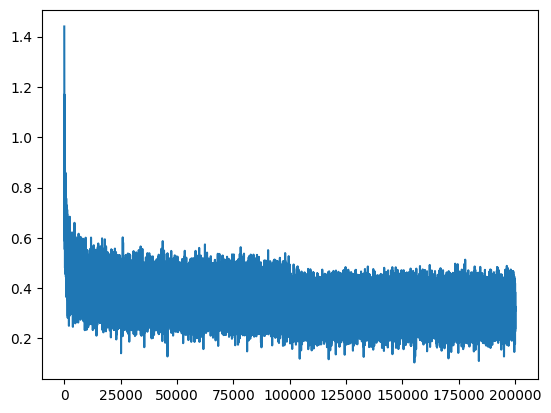

In [57]:
plt.plot(stepi, lossi);

In [58]:
# validation loss
loss_fn(params, Xdev, Ydev, jax.random.fold_in(key, i:=i+1))

DeviceArray(2.22608, dtype=float32)

In [59]:
# Test loss
loss_fn(params, Xte, Yte, jax.random.fold_in(key, i:=i+1))

DeviceArray(2.1606948, dtype=float32)

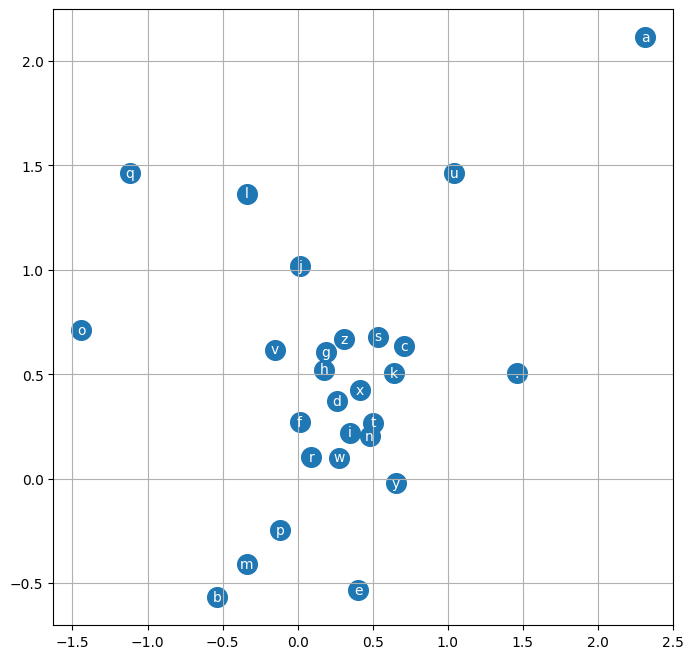

In [65]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
C = params.C
plt.figure(figsize=(8,8))
plt.scatter(C[:,0], C[:,1], s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0], C[i,1], itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [66]:
# sample from the model
# g = torch.Generator().manual_seed(2147483647 + 10)

i = 0
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      step_key = jax.random.fold_in(key, i := i+1)
      emb = C[jnp.array([context])] # (1,block_size,d)
      h = jnp.tanh(jnp.matmul(emb.reshape(-1, 30), params.W1) + params.b1) # (32, 100)
      logits = h @ params.W2 + params.b2
      ix = jax.random.categorical(step_key, logits).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

halin.
alyn.
skellon.
afelie.
ruknystheimobia.
rom.
artyeun.
jayko.
kiah.
nzael.
brodul.
missa.
rhaydeckly.
rhanaleigh.
bra.
faesy.
brania.
marwi.
ley.
ruynn.
